In [141]:
import numpy as np
import matplotlib.pyplot as plt

def iterateValue(value, getStatesIter, getActionsIter, getStateTransitionsIter, 
                 gamma=1.0, max_iter=None, Theta=np.finfo(value.dtype).resolution):
    it = 1
    new_value = np.array(value)
    while True:
        delta = 0.0
        print("Iteration {}".format(it), end="", flush=True)
        for state in getStatesIter():
            qsa = [np.sum([prob*(reward + gamma*value[next_state])
                           for next_state, prob, reward 
                           in getStateTransitionsIter(state,action)]
                         )
                   for action in getActionsIter(state)]
            new_value[state] = max(qsa)
            delta = max(delta, abs(value[state]-new_value[state]))
        print("[Done] delta={}".format(delta))
        if max_iter and it >= max_iter or delta < Theta: break
        value = np.array(new_value)
        it += 1
    return new_value

def iterateInplace(value, getStatesIter, getActionsIter, getStateTransitionsIter, 
                 gamma=1.0, max_iter=None, Theta=np.finfo(value.dtype).resolution):
    it = 1
    new_value = value
    while True:
        delta = 0.0
        print("Iteration {}".format(it), end="", flush=True)
        for state in getStatesIter():
            v = value[state]
            qsa = [np.sum([prob*(reward + gamma*value[next_state])
                           for next_state, prob, reward 
                           in getStateTransitionsIter(state,action)]
                         )
                   for action in getActionsIter(state)]
            new_value[state] = max(qsa)
            delta = max(delta, abs(v-new_value[state]))
        print("[Done] delta={}".format(delta))
        if max_iter and it >= max_iter or delta < Theta: break
        it += 1
    return new_value

def getPolicy(value, getStatesIter, getActionsIter, getStateTransitionsIter, ActionAugmentation = 0.0):
    policy = np.zeros(shape=value.shape, dtype=int)
    for state in getStatesIter():
        qsa = [np.sum([prob*(reward + gamma*value[next_state])
                       for next_state, prob, reward 
                       in getStateTransitionsIter(state,action)]
                     ) + action*ActionAugmentation
               for action in getActionsIter(state)]
        policy[state] = np.argmax(qsa)
    return policy

def getAllPolicy(value, actions_num, getStatesIter, getActionsIter, getStateTransitionsIter):
    policy = np.zeros(shape=value.shape+(actions_num,), dtype=bool)
    epsilon = np.finfo(np.float64).resolution
    for state in getStatesIter():
        qsa = np.ones(shape = (actions_num,), dtype=value.dtype) * np.finfo(np.float64).min
        for action in getActionsIter(state):
            qsa[action] = np.sum([prob*(reward + gamma*value[next_state])
                       for next_state, prob, reward 
                       in getStateTransitionsIter(state,action)]
                      )
        qsa_max = max(qsa)
        policy[state] = qsa_max-epsilon <= qsa
    return policy

In [148]:
def getGamblerStatesIter(goal):
    return range(1, goal)

def getGamblerActionsIter(state, goal):
    return range(0, min(state, goal-state)+1)

def getGamblerTransitionsIter(state, action, goal, win_prob):
    return iter([(state-action, 1.0-win_prob, 0.0),
            (min(state+action, goal), win_prob, float(state+action >= goal))])

In [149]:
goal = 100
win_prob = 0.4
gamma = 1.0
value = np.zeros(goal+1, dtype=np.float64)

In [150]:
result = iterateInplace(value, 
                       lambda: getGamblerStatesIter(goal), 
                       lambda s: getGamblerActionsIter(s,goal),
                       lambda s,a: getGamblerTransitionsIter(s,a,goal,win_prob), 
                       gamma = 1.0, 
                       max_iter=40, 
                       Theta = np.float64(1.e-26))

Iteration 1[Done] delta=0.9533440000000001
Iteration 2[Done] delta=0.3688960000000001
Iteration 3[Done] delta=0.13926400000000005
Iteration 4[Done] delta=0.05570560000000002
Iteration 5[Done] delta=0.02228224000000001
Iteration 6[Done] delta=0.008912896000000003
Iteration 7[Done] delta=0.0016384000000000008
Iteration 8[Done] delta=0.0003932160000000005
Iteration 9[Done] delta=7.602595430399994e-05
Iteration 10[Done] delta=3.041038172160032e-05
Iteration 11[Done] delta=2.6418075402233343e-06
Iteration 12[Done] delta=9.045549017728909e-07
Iteration 13[Done] delta=7.815354352569415e-08
Iteration 14[Done] delta=1.8756850440893036e-08
Iteration 15[Done] delta=5.230363003816407e-09
Iteration 16[Done] delta=1.869841788348925e-09
Iteration 17[Done] delta=7.479367151660976e-10
Iteration 18[Done] delta=1.8698417900836484e-10
Iteration 19[Done] delta=4.8203025772297625e-11
Iteration 20[Done] delta=1.928121030891905e-11
Iteration 21[Done] delta=1.6749952119754496e-12
Iteration 22[Done] delta=5.735

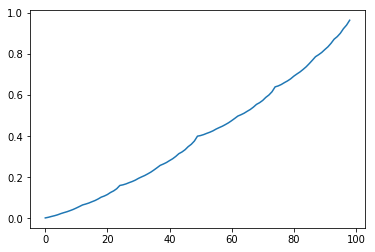

In [151]:
value = result
plt.plot(result[1:100])

### Set of optimal policies

In [152]:
policy = getAllPolicy(value,
                   51,
                   lambda: getGamblerStatesIter(goal), 
                   lambda s: getGamblerActionsIter(s,goal),
                   lambda s,a: getGamblerTransitionsIter(s,a,goal,win_prob))

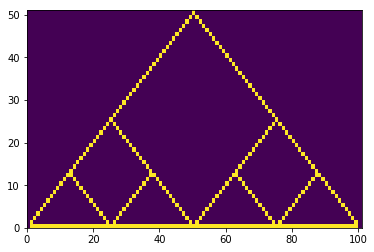

In [153]:
plt.pcolor(policy.transpose())

### Highest optimal policy

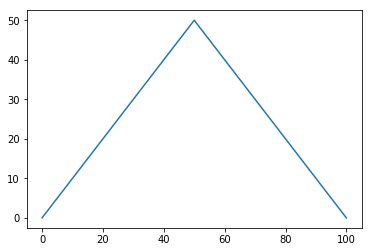

In [156]:
policy = getPolicy(value, 
                   lambda: getGamblerStatesIter(goal), 
                   lambda s: getGamblerActionsIter(s,goal),
                   lambda s,a: getGamblerTransitionsIter(s,a,goal,win_prob),
                   ActionAugmentation=np.finfo(np.float64).resolution)

plt.plot(policy)

### Lowest optimal policy

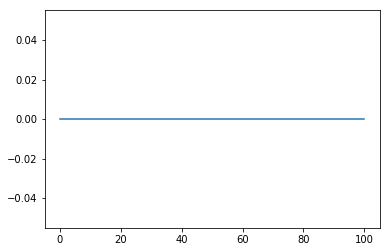

In [157]:
policy = getPolicy(value, 
                   lambda: getGamblerStatesIter(goal), 
                   lambda s: getGamblerActionsIter(s,goal),
                   lambda s,a: getGamblerTransitionsIter(s,a,goal,win_prob),
                   ActionAugmentation=-np.finfo(np.float64).resolution)

plt.plot(policy)

### Lowest nonzero optimal policy

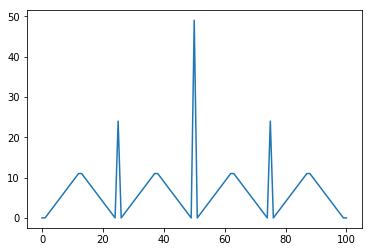

In [160]:
policy = getPolicy(value, 
                   lambda: getGamblerStatesIter(goal), 
                   lambda s: range(1, min(s, goal-s)+1),
                   lambda s,a: getGamblerTransitionsIter(s,a,goal,win_prob),
                   ActionAugmentation=-np.finfo(np.float64).resolution)

plt.plot(policy)

### Exercise 4.9

In [163]:
goal = 100
win_prob = 0.25
gamma = 1.0
value = np.zeros(goal+1, dtype=np.float64)

result_025 = iterateInplace(value, 
                       lambda: getGamblerStatesIter(goal), 
                       lambda s: getGamblerActionsIter(s,goal),
                       lambda s,a: getGamblerTransitionsIter(s,a,goal,win_prob), 
                       gamma = 1.0, 
                       max_iter=40, 
                       Theta = np.float64(1.e-26))

Iteration 1[Done] delta=0.822021484375
Iteration 2[Done] delta=0.190673828125
Iteration 3[Done] delta=0.042724609375
Iteration 4[Done] delta=0.01068115234375
Iteration 5[Done] delta=0.0026702880859375
Iteration 6[Done] delta=0.000667572021484375
Iteration 7[Done] delta=0.00011587142944335938
Iteration 8[Done] delta=2.1725893020629883e-05
Iteration 9[Done] delta=5.431473255157471e-06
Iteration 10[Done] delta=1.3578683137893677e-06
Iteration 11[Done] delta=3.394670784473419e-07
Iteration 12[Done] delta=3.580316842999309e-08
Iteration 13[Done] delta=6.713094080623705e-09
Iteration 14[Done] delta=5.31016230986836e-10
Iteration 15[Done] delta=1.32754057746709e-10
Iteration 16[Done] delta=3.318851443667725e-11
Iteration 17[Done] delta=6.222846023196116e-12
Iteration 18[Done] delta=1.1667836835593803e-12
Iteration 19[Done] delta=2.916959208898451e-13
Iteration 20[Done] delta=7.292398022246127e-14
Iteration 21[Done] delta=1.8230995055615318e-14
Iteration 22[Done] delta=1.923808334858279e-15
It

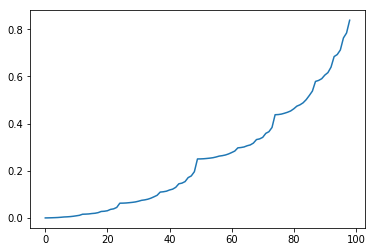

In [164]:
plt.plot(result_025[1:100])

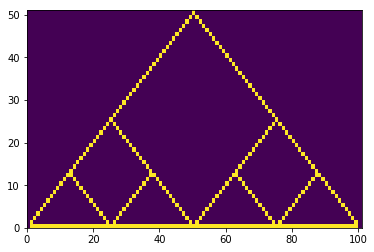

In [166]:
policy_025 = getAllPolicy(result_025,
                   51,
                   lambda: getGamblerStatesIter(goal), 
                   lambda s: getGamblerActionsIter(s,goal),
                   lambda s,a: getGamblerTransitionsIter(s,a,goal,win_prob))
plt.pcolor(policy_025.transpose())

In [ ]:
goal = 100
win_prob = 0.55
gamma = 1.0
value = np.zeros(goal+1, dtype=np.float64)

result_055 = iterateInplace(value, 
                       #lambda: getGamblerStatesIter(goal), 
                       lambda: range(99,0,-1),
                       lambda s: getGamblerActionsIter(s,goal),
                       lambda s,a: getGamblerTransitionsIter(s,a,goal,win_prob), 
                       gamma = 1.0, 
                       max_iter=2000, 
                       Theta = np.float64(1.e-16))

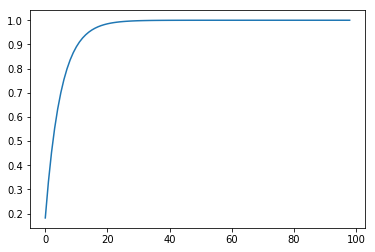

In [207]:
plt.plot(result_055[1:100])

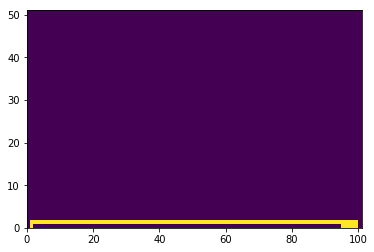

In [208]:
policy_055 = getAllPolicy(result_055,
                   51,
                   lambda: getGamblerStatesIter(goal), 
                   lambda s: getGamblerActionsIter(s,goal),
                   lambda s,a: getGamblerTransitionsIter(s,a,goal,win_prob))
plt.pcolor(policy_055.transpose())

### Exercise 4.10

Answer:
\begin{equation*}
q_{k+1}(s,a)=\sum_{s',r}p(s',r|s,a)\big[r+\gamma \max_{a'}q_{k}(s',a')\big] \\
\end{equation*}

### Testing and other stuff 

In [ ]:
def getQ(value, q, getStatesIter, getActionsIter, getStateTransitionsIter):
    for state in getStatesIter():
        for action in getActionsIter(state):
            dist = getStateTransitionsIter(state,action)
            q[state,action] = np.sum([prob*(reward + gamma*value[next_state])
                           for next_state, prob, reward in dist])


In [ ]:
result = iterateInplace(value, getGamblerStatesIter, all_actions,#getGamblerActionsIter,
                  all_transitions, max_iter=100)#, Theta=0.001)

In [ ]:
q_func = np.zeros(shape = (goal+1,goal+1,), dtype = np.float32)
getQ(value, q_func, getGamblerStatesIter, getGamblerActionsIter, getGamblerTransitionsIter)
plt.pcolor(q_func)

In [125]:
state=10
actions_num=51
epsilon = np.finfo(np.float64).resolution
qsa = np.ones(shape = (actions_num,), dtype=value.dtype) * np.finfo(np.float64).min
for action in getGamblerActionsIter(state,100):
            qsa[action] = np.sum([prob*(reward + gamma*value[next_state])
                       for next_state, prob, reward 
                       in getGamblerTransitionsIter(state,action,100,0.4)]
                      )
qsa_max = max(qsa)
p10 = qsa_max-epsilon <= qsa